In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
train_data = pd.read_csv('train.csv', index_col='PassengerId')
test_data = pd.read_csv('test.csv', index_col='PassengerId')

In [5]:
# train_data['Title'] = train_data['Name'].map(lambda name : name.split(',')[1].split('.')[0].strip())
# train_data['Title'] = train_data['Title'].map(title_dict)
# title_dummies = pd.get_dummies(train_data['Title'], prefix='Title', drop_first=True)
# data = pd.concat([train_data, title_dummies], axis=1)
    
# # finish off by removing name and ticket number
# # could be used for further prediction by using NLP, etc.
# train_data.drop(columns=['Name', 'Ticket'], inplace=True)
# agemean = train_data.groupby(by=['Sex','Pclass','Title']).mean()['Age']
# agestd = train_data.groupby(by=['Sex','Pclass','Title']).std()['Age']
# agemean = agemean.reset_index()
# agestd = agestd.reset_index()

In [6]:
def fill_age(row, agegroupsmean, agegroupsstd):
    condition = (
        (agegroupsmean['Sex'] == row['Sex']) &
        (agegroupsmean['Title'] == row['Title']) &
        (agegroupsmean['Pclass'] == row['Pclass']))
    if np.isnan(agegroupsmean[condition]['Age'].values[0]):
        condition = (
            (agegroupsmean['Sex'] == row['Sex']) &
            (agegroupsmean['Pclass'] == row['Pclass']))
        
    return agegroupsmean[condition]['Age'].values[0], agegroupsstd[condition]['Age'].values[0]

In [7]:
title_dict = {
    'Capt' : 'Officer',
    'Col' : 'Officer',
    'Major' : 'Officer',
    'Jonkheer' : 'Royalty',
    'Don' : 'Royalty',
    'Sir' : 'Royalty',
    'Dr' : 'Officer',
    'Rev' : 'Officer',
    'the Countess' : 'Royalty',
    'Mme' : 'Mrs',
    'Mlle' : 'Miss',
    'Ms' : 'Miss',
    'Mr' : 'Mr',
    'Mrs' : 'Mrs',
    'Miss' : 'Miss',
    'Master' : 'Royalty',
    'Lady' : 'Royalty'
}

def cleanTitanicData(data):
    data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
    data['Singleton'] = data['FamilySize'].map(lambda x : 1 if x == 1 else 0)
    data['SmallFamily'] = data['FamilySize'].map(lambda s : 1 if 2 <= s <= 4 else 0)
    data['LargeFamily'] = data['FamilySize'].map(lambda s : 1 if s > 4 else 0)
    # convert sex to a binary variable
    data['Sex'] = data['Sex'].apply(lambda x : 1 if x == 'male' else 0)
    
    # convert embarked to dummy variables
    common_value = 'S'
    data['Embarked'] = data['Embarked'].fillna(common_value)
    data = pd.concat([data, pd.get_dummies(data['Embarked'])], axis=1)
    data.drop('Embarked', axis=1, inplace=True)
    
    # convert cabin to dummy variable
    data['Cabin'] = data['Cabin'].fillna("U0")
    data['Cabin'] = data['Cabin'].map(lambda s : s[0])
    cabin_dummies = pd.get_dummies(data['Cabin'], prefix='Cabin', drop_first=True)
    data = pd.concat([data, cabin_dummies], axis=1)
    data.drop('Cabin', axis=1, inplace=True)
    
    data['Title'] = data['Name'].map(lambda name : name.split(',')[1].split('.')[0].strip())
    data['Title'] = data['Title'].map(title_dict)
    title_dummies = pd.get_dummies(data['Title'], prefix='Title', drop_first=True)
    data = pd.concat([data, title_dummies], axis=1)
    
    # finish off by removing name and ticket number
    # could be used for further prediction by using NLP, etc.
    data.drop(columns=['Name', 'Ticket'], inplace=True)
    agemean = pd.DataFrame(data.groupby(by=['Sex','Pclass','Title']).mean()['Age'])
    agestd = pd.DataFrame(data.groupby(by=['Sex','Pclass','Title']).std()['Age'])
    agemean = agemean.reset_index()
    agestd = agestd.reset_index()
    
    count = 1
    for i in range(1, data.shape[0]+1):
        try:
            isnan = data['Age'].isna()[i]
            if isnan:
                mean, std = fill_age(data.iloc[i,:], agemean,agestd)
                # print (mean, std)
                val = np.random.normal(loc=mean, scale=std)
                while val < 0:
                    val = np.random.normal(loc=mean, scale=std)
                data.at[i, 'Age'] = val
        except:
            pass
    
    # convert fare to deciles
    # bins = pd.qcut(data['Fare'], 5, labels=False)
    # bins = pd.DataFrame(bins)
    # data['Fare'] = bins['Fare']
    if 'Cabin_T' in data.columns:
        data.drop('Cabin_T', axis=1, inplace=True)
    data.drop('Title', axis=1, inplace=True)
    
    return data

In [8]:
test_data = cleanTitanicData(test_data)

train_data = cleanTitanicData(train_data)
labels = np.array(train_data['Survived'])
train_data.drop('Survived', axis=1, inplace=True)

In [9]:
train_data.head(6)

,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Singleton,SmallFamily,LargeFamily,C,Q,S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,
1,3,1,22.000000,1,0,7.2500,2,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
2,1,0,38.000000,1,0,71.2833,2,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
3,3,0,26.000000,0,0,7.9250,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,35.000000,1,0,53.1000,2,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
5,3,1,35.000000,0,0,8.0500,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
6,3,1,39.847153,0,0,8.4583,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0


In [10]:
test_data.head(6)

,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Singleton,SmallFamily,LargeFamily,C,Q,S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,
892,3,1,34.5,0,0,7.8292,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
893,3,0,47.0,1,0,7.0000,2,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
894,2,1,62.0,0,0,9.6875,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
895,3,1,27.0,0,0,8.6625,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
896,3,0,22.0,1,1,12.2875,3,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
897,3,1,14.0,0,0,9.2250,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0


In [11]:
print (train_data.columns)
print (len(train_data.columns))

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
       'Singleton', 'SmallFamily', 'LargeFamily', 'C', 'Q', 'S', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_U',
       'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty'],
      dtype='object')
24


In [12]:
train_data.shape

(891, 24)

In [13]:
test_data.shape

(418, 24)

In [14]:
train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Singleton,SmallFamily,LargeFamily,C,Q,S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,2,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0
2,1,0,38.0,1,0,71.2833,2,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
3,3,0,26.0,0,0,7.9250,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,35.0,1,0,53.1000,2,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
5,3,1,35.0,0,0,8.0500,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0


In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

In [17]:
train_data_scale = scaler.fit_transform(train_data)
test_data_scale = scaler.transform(test_data)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

In [19]:
model = tf.keras.Sequential()

In [20]:
num_features = len(train_data.columns)

In [21]:
model.add(layers.Dense(units=num_features, activation='relu'))
model.add(layers.Dense(units=num_features, activation='relu'))
model.add(layers.Dense(units=num_features, activation='relu'))
model.add(layers.Dense(units=num_features, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

W0627 22:14:07.440676 16624 deprecation.py:506] From C:\Users\tas12\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
learning_rate = 0.001

In [23]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [24]:
history = model.fit(x=train_data_scale, y=labels, epochs=5000)

W0627 22:14:07.634190 16624 deprecation.py:323] From C:\Users\tas12\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5000
891/891 [==============================] - 0s 160us/sample - loss: 0.6384 - acc: 0.7037
Epoch 2/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.5427 - acc: 0.7666
Epoch 3/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.4845 - acc: 0.8036
Epoch 4/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.4496 - acc: 0.8114
Epoch 5/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.4219 - acc: 0.8339
Epoch 6/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.4007 - acc: 0.8429
Epoch 7/5000
891/891 [==============================] - 0s 52us/sample - loss: 0.3903 - acc: 0.8395
Epoch 8/5000
891/891 [==============================] - 0s 59us/sample - loss: 0.3808 - acc: 0.8429
Epoch 9/5000
891/891 [==============================] - 0s 74us/sample - loss: 0.3777 - acc: 0.8350
Epoch 10/5000
891/891 [==============================] - 0s 59us/sample - loss: 0.3690 - acc: 0.850

891/891 [==============================] - 0s 48us/sample - loss: 0.2184 - acc: 0.9057
Epoch 163/5000
891/891 [==============================] - 0s 44us/sample - loss: 0.2193 - acc: 0.9080
Epoch 164/5000
891/891 [==============================] - 0s 41us/sample - loss: 0.2145 - acc: 0.9169
Epoch 165/5000
891/891 [==============================] - 0s 44us/sample - loss: 0.2150 - acc: 0.9113
Epoch 166/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.2161 - acc: 0.9068
Epoch 167/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.2115 - acc: 0.9125
Epoch 168/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.2126 - acc: 0.9113
Epoch 169/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.2147 - acc: 0.9035
Epoch 170/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.2146 - acc: 0.9068
Epoch 171/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.2121 - acc: 0.

891/891 [==============================] - 0s 64us/sample - loss: 0.1730 - acc: 0.9338
Epoch 323/5000
891/891 [==============================] - 0s 67us/sample - loss: 0.1830 - acc: 0.9237
Epoch 324/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.1796 - acc: 0.9248
Epoch 325/5000
891/891 [==============================] - 0s 55us/sample - loss: 0.1866 - acc: 0.9304
Epoch 326/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.1808 - acc: 0.9259
Epoch 327/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.1810 - acc: 0.9304
Epoch 328/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.1795 - acc: 0.9327
Epoch 329/5000
891/891 [==============================] - 0s 73us/sample - loss: 0.1778 - acc: 0.9270
Epoch 330/5000
891/891 [==============================] - 0s 74us/sample - loss: 0.1830 - acc: 0.9214
Epoch 331/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.1768 - acc: 0.

891/891 [==============================] - 0s 58us/sample - loss: 0.1636 - acc: 0.9270
Epoch 483/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.1631 - acc: 0.9360
Epoch 484/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.1608 - acc: 0.9304
Epoch 485/5000
891/891 [==============================] - 0s 57us/sample - loss: 0.1623 - acc: 0.9315
Epoch 486/5000
891/891 [==============================] - 0s 44us/sample - loss: 0.1618 - acc: 0.9371
Epoch 487/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.1627 - acc: 0.9338
Epoch 488/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.1609 - acc: 0.9315
Epoch 489/5000
891/891 [==============================] - 0s 85us/sample - loss: 0.1668 - acc: 0.9282
Epoch 490/5000
891/891 [==============================] - 0s 92us/sample - loss: 0.1609 - acc: 0.9315
Epoch 491/5000
891/891 [==============================] - 0s 77us/sample - loss: 0.1557 - acc: 0.

891/891 [==============================] - 0s 57us/sample - loss: 0.1461 - acc: 0.9416
Epoch 643/5000
891/891 [==============================] - 0s 55us/sample - loss: 0.1419 - acc: 0.9428
Epoch 644/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.1450 - acc: 0.9428
Epoch 645/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1445 - acc: 0.9428
Epoch 646/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1444 - acc: 0.9371
Epoch 647/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.1391 - acc: 0.9450
Epoch 648/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.1391 - acc: 0.9473
Epoch 649/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.1498 - acc: 0.9360
Epoch 650/5000
891/891 [==============================] - 0s 55us/sample - loss: 0.1499 - acc: 0.9383
Epoch 651/5000
891/891 [==============================] - 0s 58us/sample - loss: 0.1566 - acc: 0.

891/891 [==============================] - 0s 46us/sample - loss: 0.1448 - acc: 0.9383
Epoch 803/5000
891/891 [==============================] - 0s 73us/sample - loss: 0.1511 - acc: 0.9394
Epoch 804/5000
891/891 [==============================] - 0s 63us/sample - loss: 0.1453 - acc: 0.9383
Epoch 805/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1518 - acc: 0.9383
Epoch 806/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1497 - acc: 0.9405
Epoch 807/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.1352 - acc: 0.9484
Epoch 808/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.1416 - acc: 0.9371
Epoch 809/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.1454 - acc: 0.9439
Epoch 810/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.1529 - acc: 0.9338
Epoch 811/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.1514 - acc: 0.

891/891 [==============================] - 0s 57us/sample - loss: 0.1499 - acc: 0.9383
Epoch 963/5000
891/891 [==============================] - 0s 57us/sample - loss: 0.1380 - acc: 0.9439
Epoch 964/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.1409 - acc: 0.9416
Epoch 965/5000
891/891 [==============================] - 0s 66us/sample - loss: 0.1341 - acc: 0.9473
Epoch 966/5000
891/891 [==============================] - 0s 75us/sample - loss: 0.1336 - acc: 0.9405
Epoch 967/5000
891/891 [==============================] - 0s 67us/sample - loss: 0.1315 - acc: 0.9506
Epoch 968/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.1285 - acc: 0.9450
Epoch 969/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1263 - acc: 0.9529
Epoch 970/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1273 - acc: 0.9461
Epoch 971/5000
891/891 [==============================] - 0s 58us/sample - loss: 0.1280 - acc: 0.

891/891 [==============================] - 0s 51us/sample - loss: 0.1281 - acc: 0.9517
Epoch 1121/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.1259 - acc: 0.9506
Epoch 1122/5000
891/891 [==============================] - 0s 44us/sample - loss: 0.1260 - acc: 0.9473
Epoch 1123/5000
891/891 [==============================] - 0s 41us/sample - loss: 0.1316 - acc: 0.9428
Epoch 1124/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.1331 - acc: 0.9450
Epoch 1125/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1387 - acc: 0.9439
Epoch 1126/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.1404 - acc: 0.9416
Epoch 1127/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1343 - acc: 0.9461
Epoch 1128/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1278 - acc: 0.9461
Epoch 1129/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.1257 

891/891 [==============================] - 0s 47us/sample - loss: 0.1233 - acc: 0.9473
Epoch 1279/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.1187 - acc: 0.9506
Epoch 1280/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.1194 - acc: 0.9517
Epoch 1281/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.1162 - acc: 0.9517
Epoch 1282/5000
891/891 [==============================] - 0s 43us/sample - loss: 0.1247 - acc: 0.9517
Epoch 1283/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.1175 - acc: 0.9540
Epoch 1284/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.1164 - acc: 0.9529
Epoch 1285/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.1171 - acc: 0.9517
Epoch 1286/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.1218 - acc: 0.9428
Epoch 1287/5000
891/891 [==============================] - 0s 44us/sample - loss: 0.1294 

891/891 [==============================] - 0s 77us/sample - loss: 0.1136 - acc: 0.9529
Epoch 1437/5000
891/891 [==============================] - 0s 85us/sample - loss: 0.1198 - acc: 0.9484
Epoch 1438/5000
891/891 [==============================] - 0s 107us/sample - loss: 0.1181 - acc: 0.9517
Epoch 1439/5000
891/891 [==============================] - 0s 72us/sample - loss: 0.1178 - acc: 0.9506
Epoch 1440/5000
891/891 [==============================] - 0s 69us/sample - loss: 0.1147 - acc: 0.9495
Epoch 1441/5000
891/891 [==============================] - 0s 77us/sample - loss: 0.1222 - acc: 0.9461
Epoch 1442/5000
891/891 [==============================] - 0s 65us/sample - loss: 0.1170 - acc: 0.9517
Epoch 1443/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.1219 - acc: 0.9484
Epoch 1444/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.1153 - acc: 0.9529
Epoch 1445/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.1141

891/891 [==============================] - 0s 60us/sample - loss: 0.1299 - acc: 0.9506
Epoch 1595/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.1166 - acc: 0.9506
Epoch 1596/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1270 - acc: 0.9529
Epoch 1597/5000
891/891 [==============================] - 0s 58us/sample - loss: 0.1159 - acc: 0.9529
Epoch 1598/5000
891/891 [==============================] - 0s 74us/sample - loss: 0.1096 - acc: 0.9517
Epoch 1599/5000
891/891 [==============================] - 0s 59us/sample - loss: 0.1114 - acc: 0.9540
Epoch 1600/5000
891/891 [==============================] - 0s 75us/sample - loss: 0.1114 - acc: 0.9574
Epoch 1601/5000
891/891 [==============================] - 0s 72us/sample - loss: 0.1102 - acc: 0.9562
Epoch 1602/5000
891/891 [==============================] - 0s 59us/sample - loss: 0.1107 - acc: 0.9551
Epoch 1603/5000
891/891 [==============================] - 0s 60us/sample - loss: 0.1216 

891/891 [==============================] - 0s 44us/sample - loss: 0.1028 - acc: 0.9585
Epoch 1753/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.1037 - acc: 0.9585
Epoch 1754/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1056 - acc: 0.9551
Epoch 1755/5000
891/891 [==============================] - 0s 44us/sample - loss: 0.1055 - acc: 0.9562
Epoch 1756/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1072 - acc: 0.9596
Epoch 1757/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1080 - acc: 0.9517
Epoch 1758/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.1028 - acc: 0.9562
Epoch 1759/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.1089 - acc: 0.9562
Epoch 1760/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1111 - acc: 0.9540
Epoch 1761/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1112 

891/891 [==============================] - 0s 57us/sample - loss: 0.1080 - acc: 0.9529
Epoch 1911/5000
891/891 [==============================] - 0s 55us/sample - loss: 0.1140 - acc: 0.9529
Epoch 1912/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.1176 - acc: 0.9495
Epoch 1913/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.1303 - acc: 0.9473
Epoch 1914/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.1433 - acc: 0.9517
Epoch 1915/5000
891/891 [==============================] - 0s 58us/sample - loss: 0.1297 - acc: 0.9495
Epoch 1916/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.1256 - acc: 0.9495
Epoch 1917/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.1248 - acc: 0.9506
Epoch 1918/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.1080 - acc: 0.9562
Epoch 1919/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1066 

891/891 [==============================] - 0s 55us/sample - loss: 0.1038 - acc: 0.9585
Epoch 1990/5000
891/891 [==============================] - 0s 67us/sample - loss: 0.1048 - acc: 0.9551
Epoch 1991/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1045 - acc: 0.9596
Epoch 1992/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.1023 - acc: 0.9585
Epoch 1993/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1005 - acc: 0.9574
Epoch 1994/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1022 - acc: 0.9562
Epoch 1995/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.1055 - acc: 0.9529
Epoch 1996/5000
891/891 [==============================] - 0s 57us/sample - loss: 0.1166 - acc: 0.9517
Epoch 1997/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.1072 - acc: 0.9585
Epoch 1998/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1108 

891/891 [==============================] - 0s 52us/sample - loss: 0.1391 - acc: 0.9461
Epoch 2148/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.1401 - acc: 0.9529
Epoch 2149/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1135 - acc: 0.9529
Epoch 2150/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.1033 - acc: 0.9596
Epoch 2151/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.1105 - acc: 0.9529
Epoch 2152/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1008 - acc: 0.9607
Epoch 2153/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1033 - acc: 0.9574
Epoch 2154/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.1034 - acc: 0.9562
Epoch 2155/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.1044 - acc: 0.9574
Epoch 2156/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1009 

891/891 [==============================] - 0s 55us/sample - loss: 0.0987 - acc: 0.9607
Epoch 2306/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.0960 - acc: 0.9630
Epoch 2307/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.0956 - acc: 0.9574
Epoch 2308/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.0955 - acc: 0.9596
Epoch 2309/5000
891/891 [==============================] - 0s 59us/sample - loss: 0.0943 - acc: 0.9607
Epoch 2310/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.1002 - acc: 0.9551
Epoch 2311/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.0980 - acc: 0.9607
Epoch 2312/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.0941 - acc: 0.9585
Epoch 2313/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.0944 - acc: 0.9630
Epoch 2314/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.0960 

891/891 [==============================] - 0s 59us/sample - loss: 0.0942 - acc: 0.9675
Epoch 2464/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.0946 - acc: 0.9618
Epoch 2465/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.0938 - acc: 0.9618
Epoch 2466/5000
891/891 [==============================] - 0s 44us/sample - loss: 0.0927 - acc: 0.9596
Epoch 2467/5000
891/891 [==============================] - 0s 55us/sample - loss: 0.0943 - acc: 0.9618
Epoch 2468/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.0933 - acc: 0.9630
Epoch 2469/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.0893 - acc: 0.9630
Epoch 2470/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.0945 - acc: 0.9618
Epoch 2471/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1081 - acc: 0.9585
Epoch 2472/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.0985 

891/891 [==============================] - 0s 56us/sample - loss: 0.0958 - acc: 0.9596
Epoch 2622/5000
891/891 [==============================] - 0s 59us/sample - loss: 0.0904 - acc: 0.9596
Epoch 2623/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.0884 - acc: 0.9641
Epoch 2624/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.0853 - acc: 0.9641
Epoch 2625/5000
891/891 [==============================] - 0s 43us/sample - loss: 0.0928 - acc: 0.9652
Epoch 2626/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1002 - acc: 0.9551
Epoch 2627/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.0996 - acc: 0.9585
Epoch 2628/5000
891/891 [==============================] - 0s 69us/sample - loss: 0.1119 - acc: 0.9562
Epoch 2629/5000
891/891 [==============================] - 0s 55us/sample - loss: 0.1055 - acc: 0.9540
Epoch 2630/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.1077 

Epoch 2779/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.0908 - acc: 0.9596
Epoch 2780/5000
891/891 [==============================] - 0s 69us/sample - loss: 0.0874 - acc: 0.9607
Epoch 2781/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.0911 - acc: 0.9652
Epoch 2782/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.0882 - acc: 0.9652
Epoch 2783/5000
891/891 [==============================] - 0s 55us/sample - loss: 0.0947 - acc: 0.9596
Epoch 2784/5000
891/891 [==============================] - 0s 55us/sample - loss: 0.0976 - acc: 0.9574
Epoch 2785/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.0905 - acc: 0.9641
Epoch 2786/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.0946 - acc: 0.9663
Epoch 2787/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.0912 - acc: 0.9618
Epoch 2788/5000
891/891 [==============================] - 0s 51us/sample

891/891 [==============================] - 0s 71us/sample - loss: 0.0888 - acc: 0.9630
Epoch 2937/5000
891/891 [==============================] - 0s 58us/sample - loss: 0.1032 - acc: 0.9529
Epoch 2938/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.0935 - acc: 0.9630
Epoch 2939/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.0868 - acc: 0.9596
Epoch 2940/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.0858 - acc: 0.9641
Epoch 2941/5000
891/891 [==============================] - 0s 55us/sample - loss: 0.0854 - acc: 0.9652
Epoch 2942/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.0835 - acc: 0.9663
Epoch 2943/5000
891/891 [==============================] - 0s 68us/sample - loss: 0.0854 - acc: 0.9641
Epoch 2944/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.0879 - acc: 0.9630
Epoch 2945/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.0843 

891/891 [==============================] - 0s 62us/sample - loss: 0.1033 - acc: 0.9562
Epoch 3095/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.1130 - acc: 0.9574
Epoch 3096/5000
891/891 [==============================] - 0s 57us/sample - loss: 0.0922 - acc: 0.9641
Epoch 3097/5000
891/891 [==============================] - 0s 44us/sample - loss: 0.1018 - acc: 0.9663
Epoch 3098/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.1179 - acc: 0.9506
Epoch 3099/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.2252 - acc: 0.9394
Epoch 3100/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.1823 - acc: 0.9439
Epoch 3101/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.1159 - acc: 0.9585
Epoch 3102/5000
891/891 [==============================] - 0s 63us/sample - loss: 0.1100 - acc: 0.9607
Epoch 3103/5000
891/891 [==============================] - 0s 69us/sample - loss: 0.1102 

891/891 [==============================] - 0s 38us/sample - loss: 0.0839 - acc: 0.9641
Epoch 3253/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0783 - acc: 0.9663
Epoch 3254/5000
891/891 [==============================] - 0s 39us/sample - loss: 0.0793 - acc: 0.9663
Epoch 3255/5000
891/891 [==============================] - 0s 38us/sample - loss: 0.0859 - acc: 0.9652
Epoch 3256/5000
891/891 [==============================] - 0s 39us/sample - loss: 0.0855 - acc: 0.9652
Epoch 3257/5000
891/891 [==============================] - 0s 40us/sample - loss: 0.0880 - acc: 0.9652
Epoch 3258/5000
891/891 [==============================] - 0s 39us/sample - loss: 0.0820 - acc: 0.9630
Epoch 3259/5000
891/891 [==============================] - 0s 41us/sample - loss: 0.0848 - acc: 0.9630
Epoch 3260/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.0836 - acc: 0.9630
Epoch 3261/5000
891/891 [==============================] - 0s 41us/sample - loss: 0.0864 

891/891 [==============================] - 0s 37us/sample - loss: 0.0825 - acc: 0.9652
Epoch 3411/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0793 - acc: 0.9686
Epoch 3412/5000
891/891 [==============================] - 0s 37us/sample - loss: 0.0827 - acc: 0.9630
Epoch 3413/5000
891/891 [==============================] - 0s 35us/sample - loss: 0.0811 - acc: 0.9663
Epoch 3414/5000
891/891 [==============================] - 0s 37us/sample - loss: 0.0932 - acc: 0.9607
Epoch 3415/5000
891/891 [==============================] - 0s 37us/sample - loss: 0.0855 - acc: 0.9652
Epoch 3416/5000
891/891 [==============================] - 0s 35us/sample - loss: 0.0831 - acc: 0.9663
Epoch 3417/5000
891/891 [==============================] - 0s 35us/sample - loss: 0.0915 - acc: 0.9596
Epoch 3418/5000
891/891 [==============================] - 0s 35us/sample - loss: 0.0992 - acc: 0.9641
Epoch 3419/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0899 

891/891 [==============================] - 0s 38us/sample - loss: 0.0841 - acc: 0.9618
Epoch 3569/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0887 - acc: 0.9641
Epoch 3570/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0844 - acc: 0.9641
Epoch 3571/5000
891/891 [==============================] - 0s 44us/sample - loss: 0.0944 - acc: 0.9596
Epoch 3572/5000
891/891 [==============================] - 0s 39us/sample - loss: 0.0823 - acc: 0.9675
Epoch 3573/5000
891/891 [==============================] - 0s 39us/sample - loss: 0.0828 - acc: 0.9652
Epoch 3574/5000
891/891 [==============================] - 0s 40us/sample - loss: 0.0821 - acc: 0.9630
Epoch 3575/5000
891/891 [==============================] - 0s 39us/sample - loss: 0.0801 - acc: 0.9652
Epoch 3576/5000
891/891 [==============================] - 0s 39us/sample - loss: 0.0810 - acc: 0.9697
Epoch 3577/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.0866 

891/891 [==============================] - 0s 43us/sample - loss: 0.0910 - acc: 0.9630
Epoch 3727/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0851 - acc: 0.9675
Epoch 3728/5000
891/891 [==============================] - 0s 39us/sample - loss: 0.0849 - acc: 0.9618
Epoch 3729/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.0832 - acc: 0.9618
Epoch 3730/5000
891/891 [==============================] - 0s 40us/sample - loss: 0.0812 - acc: 0.9675
Epoch 3731/5000
891/891 [==============================] - 0s 35us/sample - loss: 0.0856 - acc: 0.9652
Epoch 3732/5000
891/891 [==============================] - 0s 38us/sample - loss: 0.0873 - acc: 0.9607
Epoch 3733/5000
891/891 [==============================] - 0s 35us/sample - loss: 0.0799 - acc: 0.9675
Epoch 3734/5000
891/891 [==============================] - 0s 40us/sample - loss: 0.0790 - acc: 0.9663
Epoch 3735/5000
891/891 [==============================] - 0s 35us/sample - loss: 0.0843 

891/891 [==============================] - 0s 35us/sample - loss: 0.0826 - acc: 0.9686
Epoch 3885/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.0773 - acc: 0.9675
Epoch 3886/5000
891/891 [==============================] - 0s 37us/sample - loss: 0.0824 - acc: 0.9630
Epoch 3887/5000
891/891 [==============================] - 0s 35us/sample - loss: 0.0838 - acc: 0.9618
Epoch 3888/5000
891/891 [==============================] - 0s 37us/sample - loss: 0.0828 - acc: 0.9652
Epoch 3889/5000
891/891 [==============================] - 0s 37us/sample - loss: 0.0900 - acc: 0.9618
Epoch 3890/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0860 - acc: 0.9686
Epoch 3891/5000
891/891 [==============================] - 0s 35us/sample - loss: 0.0787 - acc: 0.9618
Epoch 3892/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0792 - acc: 0.9630
Epoch 3893/5000
891/891 [==============================] - 0s 37us/sample - loss: 0.0800 

891/891 [==============================] - 0s 57us/sample - loss: 0.0891 - acc: 0.9686
Epoch 4043/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.0804 - acc: 0.9641
Epoch 4044/5000
891/891 [==============================] - 0s 43us/sample - loss: 0.0798 - acc: 0.9697
Epoch 4045/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0816 - acc: 0.9663
Epoch 4046/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0781 - acc: 0.9663
Epoch 4047/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.0778 - acc: 0.9618
Epoch 4048/5000
891/891 [==============================] - 0s 39us/sample - loss: 0.0784 - acc: 0.9652
Epoch 4049/5000
891/891 [==============================] - 0s 37us/sample - loss: 0.0788 - acc: 0.9675
Epoch 4050/5000
891/891 [==============================] - 0s 40us/sample - loss: 0.0729 - acc: 0.9731
Epoch 4051/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.0766 

891/891 [==============================] - 0s 44us/sample - loss: 0.0804 - acc: 0.9652
Epoch 4201/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.0882 - acc: 0.9641
Epoch 4202/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.0801 - acc: 0.9675
Epoch 4203/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.0811 - acc: 0.9618
Epoch 4204/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0821 - acc: 0.9641
Epoch 4205/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.0835 - acc: 0.9697
Epoch 4206/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.0812 - acc: 0.9686
Epoch 4207/5000
891/891 [==============================] - 0s 39us/sample - loss: 0.0807 - acc: 0.9652
Epoch 4208/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0752 - acc: 0.9731
Epoch 4209/5000
891/891 [==============================] - 0s 36us/sample - loss: 0.0728 

891/891 [==============================] - 0s 78us/sample - loss: 0.0737 - acc: 0.9663
Epoch 4359/5000
891/891 [==============================] - 0s 75us/sample - loss: 0.0779 - acc: 0.9675
Epoch 4360/5000
891/891 [==============================] - 0s 72us/sample - loss: 0.0728 - acc: 0.9686
Epoch 4361/5000
891/891 [==============================] - 0s 63us/sample - loss: 0.0848 - acc: 0.9641
Epoch 4362/5000
891/891 [==============================] - 0s 57us/sample - loss: 0.0802 - acc: 0.9663
Epoch 4363/5000
891/891 [==============================] - 0s 55us/sample - loss: 0.0846 - acc: 0.9652
Epoch 4364/5000
891/891 [==============================] - 0s 57us/sample - loss: 0.0869 - acc: 0.9719
Epoch 4365/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.0796 - acc: 0.9663
Epoch 4366/5000
891/891 [==============================] - 0s 57us/sample - loss: 0.0821 - acc: 0.9663
Epoch 4367/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.0844 

891/891 [==============================] - 0s 63us/sample - loss: 0.0734 - acc: 0.9686
Epoch 4517/5000
891/891 [==============================] - 0s 65us/sample - loss: 0.0732 - acc: 0.9697
Epoch 4518/5000
891/891 [==============================] - 0s 63us/sample - loss: 0.0792 - acc: 0.9663
Epoch 4519/5000
891/891 [==============================] - 0s 58us/sample - loss: 0.0719 - acc: 0.9697
Epoch 4520/5000
891/891 [==============================] - 0s 71us/sample - loss: 0.0784 - acc: 0.9686
Epoch 4521/5000
891/891 [==============================] - 0s 57us/sample - loss: 0.0745 - acc: 0.9686
Epoch 4522/5000
891/891 [==============================] - 0s 76us/sample - loss: 0.0787 - acc: 0.9663
Epoch 4523/5000
891/891 [==============================] - 0s 105us/sample - loss: 0.0931 - acc: 0.9663
Epoch 4524/5000
891/891 [==============================] - 0s 69us/sample - loss: 0.0928 - acc: 0.9618
Epoch 4525/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.0828

Epoch 4674/5000
891/891 [==============================] - 0s 59us/sample - loss: 0.0780 - acc: 0.9652
Epoch 4675/5000
891/891 [==============================] - 0s 63us/sample - loss: 0.0887 - acc: 0.9607
Epoch 4676/5000
891/891 [==============================] - 0s 82us/sample - loss: 0.0795 - acc: 0.9686
Epoch 4677/5000
891/891 [==============================] - 0s 69us/sample - loss: 0.0768 - acc: 0.9686
Epoch 4678/5000
891/891 [==============================] - 0s 59us/sample - loss: 0.0738 - acc: 0.9697
Epoch 4679/5000
891/891 [==============================] - 0s 58us/sample - loss: 0.0791 - acc: 0.9675
Epoch 4680/5000
891/891 [==============================] - 0s 57us/sample - loss: 0.0772 - acc: 0.9641
Epoch 4681/5000
891/891 [==============================] - 0s 64us/sample - loss: 0.0816 - acc: 0.9596
Epoch 4682/5000
891/891 [==============================] - 0s 91us/sample - loss: 0.0826 - acc: 0.9686
Epoch 4683/5000
891/891 [==============================] - 0s 65us/sample

891/891 [==============================] - 0s 49us/sample - loss: 0.0776 - acc: 0.9641
Epoch 4832/5000
891/891 [==============================] - 0s 76us/sample - loss: 0.0793 - acc: 0.9663
Epoch 4833/5000
891/891 [==============================] - 0s 47us/sample - loss: 0.0759 - acc: 0.9686
Epoch 4834/5000
891/891 [==============================] - 0s 45us/sample - loss: 0.0779 - acc: 0.9652
Epoch 4835/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.0770 - acc: 0.9652
Epoch 4836/5000
891/891 [==============================] - 0s 48us/sample - loss: 0.0757 - acc: 0.9708
Epoch 4837/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.0801 - acc: 0.9675
Epoch 4838/5000
891/891 [==============================] - 0s 64us/sample - loss: 0.0856 - acc: 0.9630
Epoch 4839/5000
891/891 [==============================] - 0s 46us/sample - loss: 0.0758 - acc: 0.9663
Epoch 4840/5000
891/891 [==============================] - 0s 41us/sample - loss: 0.0828 

891/891 [==============================] - 0s 58us/sample - loss: 0.0752 - acc: 0.9686
Epoch 4990/5000
891/891 [==============================] - 0s 54us/sample - loss: 0.0784 - acc: 0.9686
Epoch 4991/5000
891/891 [==============================] - 0s 56us/sample - loss: 0.0749 - acc: 0.9641
Epoch 4992/5000
891/891 [==============================] - 0s 66us/sample - loss: 0.0705 - acc: 0.9719
Epoch 4993/5000
891/891 [==============================] - 0s 53us/sample - loss: 0.0698 - acc: 0.9719
Epoch 4994/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.0693 - acc: 0.9731
Epoch 4995/5000
891/891 [==============================] - 0s 43us/sample - loss: 0.0698 - acc: 0.9697
Epoch 4996/5000
891/891 [==============================] - 0s 51us/sample - loss: 0.0716 - acc: 0.9708
Epoch 4997/5000
891/891 [==============================] - 0s 49us/sample - loss: 0.0709 - acc: 0.9686
Epoch 4998/5000
891/891 [==============================] - 0s 50us/sample - loss: 0.0705 

In [25]:
predictions = model.predict_classes(x=train_data_scale)

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
print (confusion_matrix(labels, predictions))

[[544   5]
 [ 24 318]]


In [28]:
print (classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       549
           1       0.98      0.93      0.96       342

    accuracy                           0.97       891
   macro avg       0.97      0.96      0.97       891
weighted avg       0.97      0.97      0.97       891



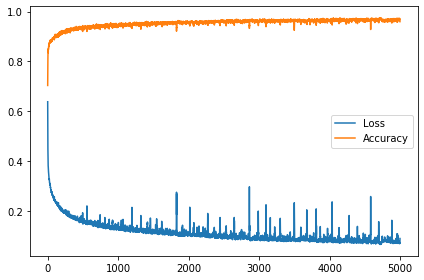

In [29]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['acc'], label='Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
predictions_test = model.predict_classes(x=test_data_scale)

In [31]:
data_predict = np.concatenate((np.array(test_data.index).reshape(len(test_data.index), 1), predictions_test), axis=1)

In [32]:
data_predict = pd.DataFrame(data=data_predict, columns=['PassengerId', 'Survived'])
data_predict = data_predict.set_index('PassengerId')
data_predict.head()

,Survived
PassengerId,
892,0
893,0
894,1
895,0
896,0


In [33]:
data_predict.to_csv('TitanicPredictions.csv')

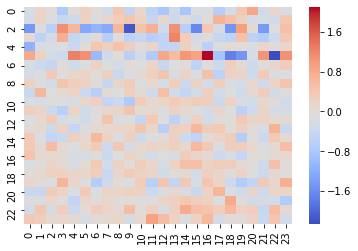

In [38]:
weights_layer_1 = np.array(model.get_weights()[0])
sns.heatmap(data=weights_layer_1, cmap='coolwarm')

In [39]:
print (train_data.columns[16], train_data.columns[5])

Cabin_E Fare
